## Линейная классификация

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [3]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Смотрим на SVM, LR 

In [4]:
# Сгенерируем синтетические данные.
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

In [5]:
X.shape

(10000, 10)

✅
- Обучите метод опорных векторов. 
- Подберите параметр регуляризации `C`, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR

In [6]:
def auc_pr(y_test, y_pred):
    precision, recall, th = precision_recall_curve(y_test, y_pred)
    return auc(recall, precision)

In [7]:
scl = StandardScaler()
X = scl.fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [9]:
def c_best_selection(C_set, clf, X_t, y_t, X_val, y_val):
    auc_p_r = 0
    C = 1.0
    
    for C_i in C_set:
        clf.C = C_i
        
        clf.fit(X_t, y_t)
        a_x = clf.predict(X_val)
        
        precision, recall, th = precision_recall_curve(y_val, a_x)
        
        auc_precision_recall = auc(recall, precision)
        
        if auc_precision_recall > auc_p_r:
            auc_p_r = auc_precision_recall
            C = C_i
            
    print("Подобранный параметр С:", C)
    return C
    

In [10]:
best_c_linearSVC = c_best_selection(np.arange(0.001, 100, 1), LinearSVC(), X_train1, y_train1, X_val,  y_val)

Подобранный параметр С: 65.00099999999999


✅ На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

### Считаем

In [11]:
clf = LinearSVC()
clf.C = best_c_linearSVC
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

In [12]:
precision, recall, th_pr = precision_recall_curve(y_test, a_x)
fpr, tpr, th_roc = roc_curve(y_test, a_x)

In [13]:
print("AUC_ROC: %0.5f" % auc(fpr, tpr))
print("AUC_PR: %0.5f"% auc(recall, precision))

AUC_ROC: 0.77990
AUC_PR: 0.83726


### Строим

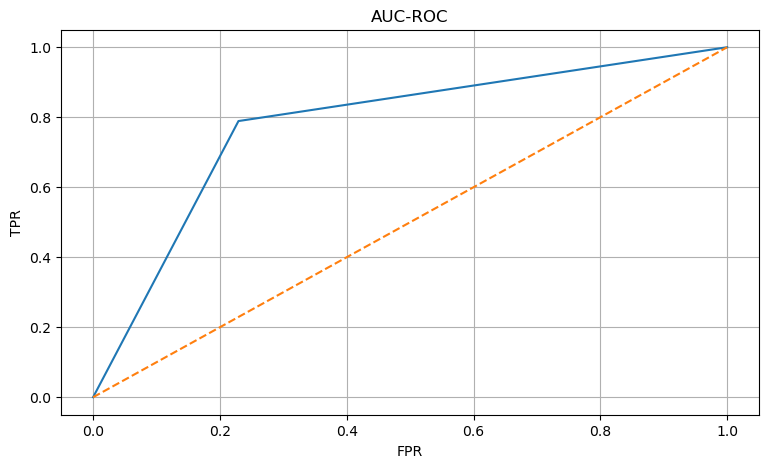

In [14]:
plt.figure(figsize=(9,5))

plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1], linestyle='--')


plt.grid(True)
plt.title('AUC-ROC')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

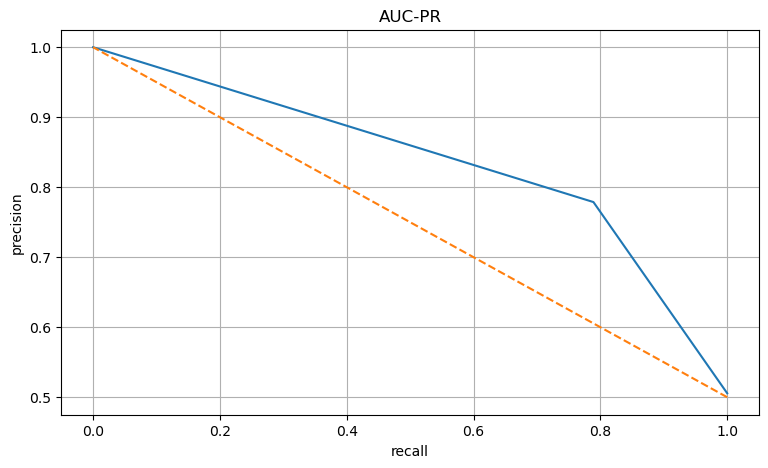

In [15]:
plt.figure(figsize=(9,5))

plt.plot(recall, precision, label="PR")
plt.plot([1, 0], [0.5, 1], linestyle='--')

plt.grid(True)
plt.title('AUC-PR')
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

✅ 
- Проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. 
- Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества.

In [16]:
best_c_LR = c_best_selection(np.arange(0.001, 100, 1), LogisticRegression(), X_train1, y_train1, X_val,  y_val)

Подобранный параметр С: 1.001


In [17]:
clf = LogisticRegression()
clf.C = best_c_LR
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

precision, recall, th_pr = precision_recall_curve(y_test, a_x)
fpr, tpr, th_roc = roc_curve(y_test, a_x)

print("AUC_ROC: %0.5f" % auc(fpr, tpr))
print("AUC_PR: %0.5f"% auc(recall, precision))

AUC_ROC: 0.77134
AUC_PR: 0.83116


### Строим

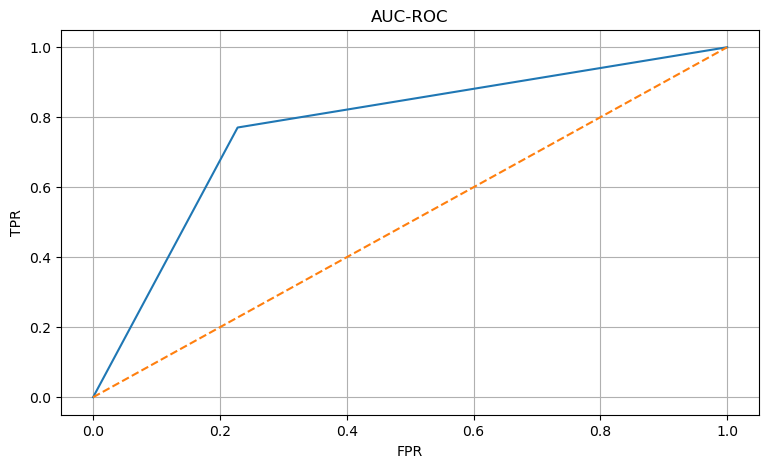

In [18]:
plt.figure(figsize=(9,5))

plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1], linestyle='--')


plt.grid(True)
plt.title('AUC-ROC')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

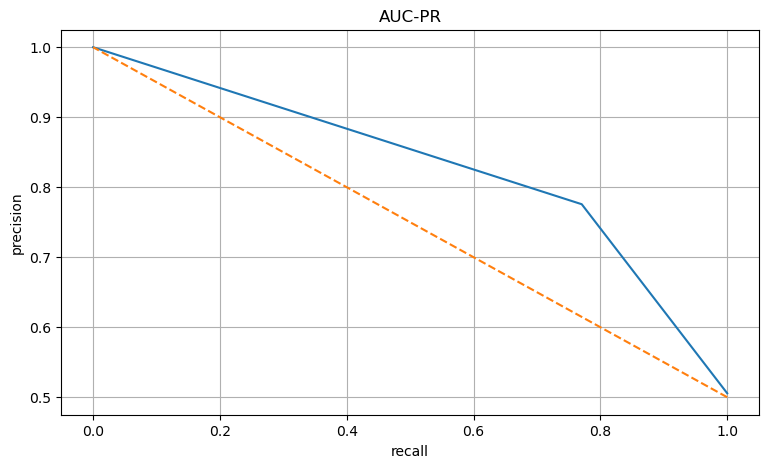

In [19]:
plt.figure(figsize=(9,5))

plt.plot(recall, precision, label="PR")
plt.plot([1, 0], [0.5, 1], linestyle='--')

plt.grid(True)
plt.title('AUC-PR')
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

# 📌 Работаем с признаками


Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

✅ Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing)

In [20]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [21]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [22]:
df.shape

(41188, 21)

✅ 
 - Разделите выборку на обучающую и тестовую в соотношении 3:1. 
 - Зафиксируйте `random_state=777`, используйте `stratify`.
 - Удалите столбец, который не несет информации для решения задачи. 



In [23]:
df["y"].unique()

array(['no', 'yes'], dtype=object)

In [24]:
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1

In [25]:
df.shape

(41188, 21)

In [26]:
df.drop(columns = 'duration', inplace = True)

✅ 
- Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

- Почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

**Разделим признаки на категориальные и вещественные**

In [27]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

### Подготовка к обучению модели

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [29]:
#для кодирования категориальных признаков используем OrdinalEncoder
enc = OrdinalEncoder()

In [30]:
#вещественные признаки также отмасштабируем
data = ColumnTransformer([
                     ('cat', enc, cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных 
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', data),
                   ('classifier', LogisticRegression())
                   ])

### Переходим к обучению 

In [31]:
df_ = pd.DataFrame({'name': ['n', 'n', 'v', 'm', 'v', 'n']})

In [32]:
df_

,name
0,n
1,n
2,v
3,m
4,v
5,n


In [33]:
enc.fit_transform(df_)

array([[1.],
       [1.],
       [2.],
       [0.],
       [2.],
       [1.]])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='y'),
                                    df['y'], test_size = 0.3,
                                    random_state=777, stratify=df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [35]:
start_time = time.time()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение OrdinalEncoder:', time.time()-start_time)
print('AUC-PR на OrdinalEncoder = %.5f' % auc_pr(y_test,y_pred))
print('Кол-во столбцов', data.fit_transform(X_train).shape[1])

Время на обучение OrdinalEncoder: 0.2901170253753662
AUC-PR на OrdinalEncoder = 0.95330
Кол-во столбцов 19


In [36]:
model

Pipeline(steps=[('enc_and_st_scaler',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.conf.idx',
                                                   'cons.price.idx',
                                                   'euribor3m',
                                                   'nr.employed'])])),
                ('classifier', LogisticRegression())])

✅
- Закодируйте все категориальные признаки с помощью one-hot-кодирования. 
- Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). 
- Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [37]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0


In [38]:
#для кодирования категориальных признаков используем OneHotEncoder
enc = OneHotEncoder(handle_unknown="ignore")

#вещественные признаки также отмасштабируем
data = ColumnTransformer([
                     ('cat', enc, cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных 
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', data),
                   ('classifier', LogisticRegression())
                   ])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='y'),
                                    df['y'], test_size = 0.3,
                                    random_state=777, stratify=df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [40]:
start_time = time.time()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение OHE:', time.time()-start_time)
print('AUC-PR на OHE = %.5f' % auc_pr(y_test,y_pred))
print('Кол-во столбцов', data.fit_transform(X_train).shape[1])

Время на обучение OHE: 0.6702940464019775
AUC-PR на OHE = 0.95339
Кол-во столбцов 62


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории. Метод предполагает кодирование категорий средним арифметическим от суммы целевых меток
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$



✅ 
- Закодируйте категориальные переменные с помощью счётчиков:

$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

- Обучите логистическую регрессию и посмотрите на качество модели на тестовой выборке. 
- Сравните с предыдущими экспериментами

In [41]:
#вещественные признаки также отмасштабируем, категориальные отмасштабируем отдельно
data = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных 
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', data),
                   ('classifier', LogisticRegression())
                   ])

### Кодирование категориальных, обучение модели и тестирование

In [42]:
start_time = time.time()

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        #используем формулу
        g_train = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0] / X_train[X_train[col] == categ].shape[0]
        X_train.loc[X_train[col] == categ, col] = g_train
        
        
        g_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0] / X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_test 

#обучение, тестировние        
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при mean-target encoding = %.5f" %  auc_pr(y_test, y_pred))
print('Кол-во столбцов ', X_train.shape[1])

Время на обучение модели: 0.8530251979827881
AUC-PR при mean-target encoding = 0.95312
Кол-во столбцов  19


✅
- Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям . 
- Снова обучите логистическую регрессию, оцените качество. 
- Сделайте выводы.


In [43]:
start_time = time.time()
for col in cat:
    #добавим шума к категориальным признакам
    X_train[col] += np.random.rand(X_train.shape[0]) * np.sign(np.random.rand(X_train.shape[0]) - 0.5) / 10
    X_test[col] += np.random.rand(X_test.shape[0]) * np.sign(np.random.rand(X_test.shape[0]) - 0.5) / 10

clf = LogisticRegression()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при mean-target encoding и шуме= %.5f" %  auc_pr(y_test, y_pred))
print('Кол-во столбцов ', X_train.shape[1])

Время на обучение модели: 0.29494237899780273
AUC-PR при mean-target encoding и шуме= 0.95217
Кол-во столбцов  19


✅ Добавьте сглаживание, а затем повторите эксперименты.

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$

In [46]:
#разделим выборку
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'y'), 
                                                    df['y'], test_size=0.3, random_state=777, stratify = df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [47]:
#вещественные признаки также отмасштабируем, категориальные отмасштабируем отдельно
date = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных 
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', date),
                   ('classifier', LogisticRegression())
                   ])

In [48]:
start_time = time.time()

C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        #добавляем долю объектов положительного класса (global_mean)
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        #добавляем долю объектов положительного класса (global_mean)
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test 
        
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" %  auc_pr(y_test, y_pred))

Время на обучение модели: 0.8590495586395264
AUC-PR при global mean = 0.95536


✅ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [49]:
#разделим выборку
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'y'), 
                                                    df['y'], test_size=0.3, random_state=777, stratify = df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [50]:
print('Кол-во уникальных возрастов', df['age'].nunique())

Кол-во уникальных возрастов 78


In [51]:
#теперь возраст категориальная переменная
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age']

num = ['campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [52]:
start_time = time.time()

C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test 
        
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" %  auc_pr(y_test, y_pred))

Время на обучение модели: 1.0540966987609863
AUC-PR при global mean = 0.96042


**Заметим, что AUC_PR стала выше**

**Домашнее задание**

✅ Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [ ]:
X = df

In [ ]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'poutcome', 'age']

num = ['campaign', 'pdays', 'previous', 'emp.var.rate', 'month', 'day_of_week',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

# 📌 Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [53]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify = y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [54]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0


✅ В данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

### Вспомним как были разделены признаки (на вещественные и категориальные)

In [55]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

### Закодируем категориальрные признаки с помощью one-hot кодирования

**Будем использовать метод get_dummies**

In [56]:
#для красивого вывода названий столбцов
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(X_train, columns = cat_mask, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask, drop_first=True)

In [57]:
X_train.shape

(28831, 52)

✅ В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. 

In [58]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

auc_pr_lr_ohe = auc_pr(y_test, a_x)

In [59]:
print("AUC_PR = %.5f" % auc_pr_lr_ohe)

AUC_PR = 0.95224


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.





✅ 
 - Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? 

In [60]:
start_time = time.time()

indices = pd.DataFrame(clf.coef_[0], [*range(52)]).sort_values(by=0).tail(40).index

x_train = X_train.iloc[:, indices.values]
x_test = X_test.iloc[:, indices.values]

clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test, a_x)

print('Время обучения модели', time.time()-start_time)
print("AUC_PR = %.5f" % auc_pr_lr_fourty)

Время обучения модели 0.4624919891357422
AUC_PR = 0.95187


### Отмасшабируем признаки с помощью StandartScaler и OHE

**Снова разделим данные**

In [61]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

### Кодирование

In [62]:
#вещественные признаки отмасштабируем с помощью StandardScaler, категориальные пока не трогаем
date = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])

X_train = pd.DataFrame(date.fit_transform(X_train))
X_test = pd.DataFrame(date.transform(X_test))

In [63]:
#кодируем категориальные признаки
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(data=X_train, columns=X_train.iloc[:, 0:10].columns, drop_first=True)
X_test = pd.get_dummies(data=X_test, columns=X_test.iloc[:, 0:10].columns, drop_first=True)

In [64]:
X_train

,10,11,12,13,14,15,16,17,18,0_blue-collar,0_entrepreneur,0_housemaid,0_management,0_retired,0_self-employed,0_services,0_student,0_technician,0_unemployed,0_unknown,1_married,1_single,1_unknown,2_basic.6y,2_basic.9y,2_high.school,2_illiterate,2_professional.course,2_university.degree,2_unknown,3_unknown,3_yes,4_unknown,4_yes,5_unknown,5_yes,6_telephone,7_aug,7_dec,7_jul,7_jun,7_mar,7_may,7_nov,7_oct,7_sep,8_mon,8_thu,8_tue,8_wed,9_nonexistent,9_success
0,-0.289536,-0.567466,0.196418,-0.351015,-2.213588,2.249459,-1.599578,-1.669748,-2.061837,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False
1,-0.958139,-0.567466,0.196418,1.665344,-1.131825,0.477886,0.781528,-1.563255,-2.419431,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,1.62076,-0.203565,0.196418,-0.351015,-0.113695,-0.321482,-0.647481,0.233315,0.399899,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
3,0.570097,-0.567466,0.196418,1.665344,-1.195458,-1.228873,-1.17796,-1.352571,-0.93521,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
4,1.42973,-0.203565,0.196418,-0.351015,0.840802,-0.278273,1.538367,0.719154,0.845855,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,1.42973,-0.203565,0.196418,-0.351015,0.840802,-0.278273,1.538367,0.718579,0.845855,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False
28827,-0.76711,-0.567466,0.196418,-0.351015,0.840802,0.953186,-0.225863,0.778445,0.845855,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False
28828,-0.480565,0.160335,0.196418,-0.351015,0.840802,-0.472714,0.593182,0.774991,0.845855,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False
28829,0.761127,-0.567466,0.196418,-0.351015,-1.195458,-1.228873,-1.17796,-1.313427,-0.93521,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False


**Теперь выберем 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модель, оценим её качество.**

In [65]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [66]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [67]:
start_time = time.time()

indices = pd.DataFrame(clf.coef_[0], [*range(52)]).sort_values(by=0).tail(40).index #Выбрали 40 лучших весов

x_train = X_train.iloc[:, indices.values] #выбрали признаки, соответствующие лучшим весам
x_test = X_test.iloc[:, indices.values]

clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test,a_x)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR (40 признаков) = %.5f" %  auc_pr_lr_fourty)
print('indices =', indices)

Время на обучение модели: 0.3549613952636719
AUC-PR (40 признаков) = 0.95215
indices = Index([16, 26, 13,  5, 47, 48, 45, 20, 29, 18,  0, 28, 11, 17, 24, 33, 25, 10,
       12,  3, 39, 31, 14, 35, 32, 34, 27, 15,  1, 44, 19,  2, 46,  9, 30, 42,
       43, 40, 36,  4],
      dtype='int64')


**Домашнее задание**

✅ one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

**Домашнее задание**

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.




✅ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.

In [ ]:
from math import sqrt

**Домашнее задание**

### Методы-обёртки


Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).


✅ Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
#ПОДГРУЗКА ДАННЫХ
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#обучающая и тестовая
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#валидационная
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#ПРЕОБРАЗОВАНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ 
y_train = y_train.astype('int')
y_train1 = y_train1.astype('int')
y_test = y_test.astype('int')
y_val = y_val.astype('int')

#КОДИРОВАНИЕ ДАННЫХ
#закодировали категории
cat_mask1 = X_train1.select_dtypes(include=['object']).columns
cat_mask2 = X_test.select_dtypes(include=['object']).columns
cat_mask3 = X_val.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train1 = pd.get_dummies(X_train1, columns = cat_mask1, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask2, drop_first=True)
X_val = pd.get_dummies(X_val, columns = cat_mask3, drop_first=True)
columns_ = X_train1.columns

#отмасштабируем все!
scaler = StandardScaler()

X_train1 = pd.DataFrame(scaler.fit_transform(X_train1))
X_test = pd.DataFrame(scaler.transform(X_test))
X_val = pd.DataFrame(scaler.transform(X_val))

X_train1.columns = columns_
X_test.columns = columns_
X_val.columns = columns_

### Начинаем отбор

✅ Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте добавлять по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. 

In [ ]:
#ПОДГРУЗКА ДАННЫХ
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#обучающая и тестовая
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#валидационная
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#ПРЕОБРАЗОВАНИЕ ЦЕЛЕЛВОЙ ПЕРЕМЕННОЙ 
y_train = y_train.astype('int')
y_train1 = y_train1.astype('int')
y_test = y_test.astype('int')
y_val = y_val.astype('int')

#КОДИРОВАНИЕ ДАННЫХ
#закодировали категории
cat_mask1 = X_train1.select_dtypes(include=['object']).columns
cat_mask2 = X_test.select_dtypes(include=['object']).columns
cat_mask3 = X_val.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train1 = pd.get_dummies(X_train1, columns = cat_mask1, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask2, drop_first=True)
X_val = pd.get_dummies(X_val, columns = cat_mask3, drop_first=True)
columns_ = X_train1.columns

#отмасштабируем все!
scaler = StandardScaler()

X_train1 = pd.DataFrame(scaler.fit_transform(X_train1))
X_test = pd.DataFrame(scaler.transform(X_test))
X_val = pd.DataFrame(scaler.transform(X_val))

X_train1.columns = columns_
X_test.columns = columns_
X_val.columns = columns_


X_train_3 = pd.DataFrame()
X_test_3 = pd.DataFrame()
X_valid_3 = pd.DataFrame()

### Отбор данных